In [2]:
# Step 1: Import required libraries
import os
import shutil

print("Listing all files in /content/:")
print(os.listdir('/content/'))

# Step 2: Unzip the dataset directly from the files tab
dataset_zip_path = '/content/leaf-detection-dataset.zip'  # Assuming the file is uploaded to /content/

print('Unzipping the dataset...')
!unzip -q {dataset_zip_path} -d /content/
print('Dataset unzipped successfully.')

# Step 3: Define the dataset path
dataset_path = '/content/leaf-detection-dataset'

# Step 4: List all files in the dataset directory
print("Contents of the dataset directory:")
print(os.listdir(dataset_path))


Listing all files in /content/:
['.config', 'leaf-detection-dataset.zip', 'sample_data']
Unzipping the dataset...
Dataset unzipped successfully.
Contents of the dataset directory:
['test', 'train', 'train.csv']


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Specific versions and imports

In [3]:
# Step 5: Install required packages
!pip install ultralytics
!pip install squarify


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.6/877.6 kB 18.4 MB/s eta 0:00:00


In [4]:
# Step 6: Import additional libraries
import random
import cv2
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

# Set seaborn style
sns.set_style('darkgrid')

%matplotlib inline


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Step 7: Define paths to CSV and images
# Define the path to the CSV file
csv_filename = 'train.csv'
csv_filepath = os.path.join(dataset_path, csv_filename)

# Define the paths to the images
train_images_path = os.path.join(dataset_path, 'train')
test_images_path = os.path.join(dataset_path, 'test')

# Verify the paths
print(f"CSV File Path: {csv_filepath}")
print(f"Train Images Path: {train_images_path}")
print(f"Test Images Path: {test_images_path}")


CSV File Path: /content/leaf-detection-dataset/train.csv
Train Images Path: /content/leaf-detection-dataset/train
Test Images Path: /content/leaf-detection-dataset/test


# Common functions

In [6]:
def csv_to_dataframe(csv_filepath, columns_name):
    df = pd.read_csv(csv_filepath, names=columns_name, header=0)
    return df

def calc_percentage(df_total, df_part, file_id_column):
    part = len(df_part[file_id_column].unique())
    total = len(df_total[file_id_column].unique())
    return (part / total) * 100

def dict_to_yaml(data):
    yaml_lines = []
    for key, value in data.items():
        if key == 'format':
            if value == 'line_break':
                yaml_lines.append('')
        elif isinstance(value, list):
            yaml_lines.append(f"{key}: {value}")
        else:
            yaml_lines.append(f"{key}: {value}")
    return '\n'.join(yaml_lines)

def create_yaml_data(yaml_file_name, output_dir, data):
    yaml_content = dict_to_yaml(data)
    output_path = os.path.join(output_dir, f'{yaml_file_name}.yaml')
    os.makedirs(output_dir, exist_ok=True)
    with open(output_path, 'w') as file:
        file.write(yaml_content)
    print(f'YAML file created successfully in {output_path}.')

def convert_bbox_to_yolo(x, y, width, height, img_width, img_height):
    x_center = (x + width / 2) / img_width
    y_center = (y + height / 2) / img_height
    width /= img_width
    height /= img_height
    return x_center, y_center, width, height

def dataframe_yolofiles(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    data = {}
    for index, row in df.iterrows():
        image_id = row['image_id']
        img_width = int(row['width'])
        img_height = int(row['height'])
        bbox = eval(row['bbox'])
        x, y, width, height = bbox
        x_center, y_center, norm_width, norm_height = convert_bbox_to_yolo(x, y, width, height, img_width, img_height)
        if image_id not in data:
            data[image_id] = []
        data[image_id].append(f"0 {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")
    for image_id, bboxes in data.items():
        output_file_path = os.path.join(output_dir, os.path.splitext(image_id)[0] + ".txt")
        with open(output_file_path, 'w') as f:
            for bbox in bboxes:
                f.write(bbox + "\n")
    print(f'Total text files created in: {output_dir}')

def move_images_to_directory(df, root_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    unique_image_ids = df['image_id'].unique()
    for image_id in unique_image_ids:
        source_path = os.path.join(root_dir, image_id)
        target_path = os.path.join(target_dir, image_id)
        if os.path.exists(source_path):
            shutil.copy(source_path, target_path)
        else:
            print(f"Warning: Image {image_id} not found on path {source_path}")
    print(f'Total images moved to: {target_dir}')

def leaf_detect_with_info(img_path, model):
    img = cv2.imread(img_path)
    results = model(img)
    result = results[0]

    # Extract detection information
    boxes = result.boxes  # Boxes object
    bbox_xyxy = boxes.xyxy.cpu().numpy()  # Bounding boxes in (xmin, ymin, xmax, ymax) format
    confidences = boxes.conf.cpu().numpy()  # Confidence scores
    class_ids = boxes.cls.cpu().numpy().astype(int)  # Class IDs

    # Convert class IDs to class names (if needed)
    class_names = [model.names[class_id] for class_id in class_ids]

    # Prepare a list of detections
    detections = []
    for i in range(len(bbox_xyxy)):
        detection = {
            'image_path': img_path,
            'leaf_id': i + 1,  # Assign a unique ID within the image
            'class_id': class_ids[i],
            'class_name': class_names[i],
            'confidence': confidences[i],
            'bbox_xmin': bbox_xyxy[i][0],
            'bbox_ymin': bbox_xyxy[i][1],
            'bbox_xmax': bbox_xyxy[i][2],
            'bbox_ymax': bbox_xyxy[i][3]
        }
        detections.append(detection)

    # Optionally, plot the detections
    detect_img = result.plot()
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    return detect_img, detections

def process_images_and_save_detections(images_dir, model, output_csv_path):
    image_files = glob.glob(os.path.join(images_dir, '*.*'))
    all_detections = []
    global_leaf_id = 1  # Global leaf ID counter

    for img_file in image_files:
        _, detections = leaf_detect_with_info(img_file, model)
        for detection in detections:
            detection['global_leaf_id'] = global_leaf_id
            global_leaf_id += 1
            all_detections.append(detection)

    # Convert the list of detections to a DataFrame
    df_detections = pd.DataFrame(all_detections)

    # Save to CSV
    df_detections.to_csv(output_csv_path, index=False)
    print(f"Detections saved to {output_csv_path}")

def show_detections_with_ids(images_dir, model, num_images=5):
    image_files = glob.glob(os.path.join(images_dir, '*.*'))
    selected_images = random.sample(image_files, min(num_images, len(image_files)))

    for img_file in selected_images:
        img = cv2.imread(img_file)
        results = model(img)
        result = results[0]

        boxes = result.boxes
        bbox_xyxy = boxes.xyxy.cpu().numpy()
        confidences = boxes.conf.cpu().numpy()
        class_ids = boxes.cls.cpu().numpy().astype(int)

        for i in range(len(bbox_xyxy)):
            xmin, ymin, xmax, ymax = bbox_xyxy[i]
            confidence = confidences[i]
            class_id = class_ids[i]
            label = f"ID:{i+1} {model.names[class_id]} {confidence:.2f}"

            # Draw the bounding box and label
            cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
            cv2.putText(img, label, (int(xmin), int(ymin) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Display the image
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


# Convert Dataset CSV to format Yolo

## Division into train(80%), validation(10%) and test(10%)

In [7]:
# Define column names
columns_name = ['image_id', 'width', 'height', 'bbox']

# Read annotations CSV
annotations = csv_to_dataframe(csv_filepath, columns_name)
df = pd.DataFrame(annotations)

# Split the DataFrame into training (80%) and validation with test (20%) based on unique file names
unique_filenames = df['image_id'].unique()
train_filenames, val_test_filenames = train_test_split(unique_filenames, test_size=0.2, random_state=random_seed)
train_df = df[df['image_id'].isin(train_filenames)]

# Split validation and test datasets (10% each)
val_filenames, test_filenames = train_test_split(val_test_filenames, test_size=0.5, random_state=random_seed)
val_df = df[df['image_id'].isin(val_filenames)]
test_df = df[df['image_id'].isin(test_filenames)]


## Create data.yaml File for YOLO

In [8]:
output_dir = '/content/yolo_dataset_leafdetection'
yaml_file_name = 'data'
yaml_data = {
    'train': f'{output_dir}/train/images',
    'val': f'{output_dir}/valid/images',
    'test': f'{output_dir}/test/images',
    'format': 'line_break',
    'nc': 1,
    'names': ['leaf']
}

create_yaml_data(yaml_file_name, output_dir, yaml_data)


YAML file created successfully in /content/yolo_dataset_leafdetection/data.yaml.


## Create Text and Image Files in Corresponding Directories


In [9]:
# Paths to all images
paths_all_images = train_images_path  # Assuming all images are in the train_images_path

# Data for train
txt_files_train = f'{output_dir}/train/labels'
img_files_train = f'{output_dir}/train/images'
move_images_to_directory(train_df, paths_all_images, img_files_train)
dataframe_yolofiles(train_df, txt_files_train)

# Data for validation
txt_files_val = f'{output_dir}/valid/labels'
img_files_val = f'{output_dir}/valid/images'
move_images_to_directory(val_df, paths_all_images, img_files_val)
dataframe_yolofiles(val_df, txt_files_val)

# Data for test
txt_files_test = f'{output_dir}/test/labels'
img_files_test = f'{output_dir}/test/images'
move_images_to_directory(test_df, paths_all_images, img_files_test)
dataframe_yolofiles(test_df, txt_files_test)


Total images moved to: /content/yolo_dataset_leafdetection/train/images
Total text files created in: /content/yolo_dataset_leafdetection/train/labels
Total images moved to: /content/yolo_dataset_leafdetection/valid/images
Total text files created in: /content/yolo_dataset_leafdetection/valid/labels
Total images moved to: /content/yolo_dataset_leafdetection/test/images
Total text files created in: /content/yolo_dataset_leafdetection/test/labels


# Model Training
To train the model with ultralytics, an apikey is required that will be requested at the time of executing the training, the site where this apikey will be obtained is at https://wandb.ai/authorize

In [10]:
# Load a pretrained YOLOv8 model
model = YOLO('yolov8n.pt')

# Train the model
model.train(data=f'{output_dir}/data.yaml',
            epochs=60,
            imgsz=416,  # Adjust according to your image size
            seed=random_seed,
            batch=8,
            workers=4)


100%|██████████| 6.25M/6.25M [00:00<00:00, 77.0MB/s]


Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/yolo_dataset_leafdetection/data.yaml, epochs=60, time=None, patience=100, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.7MB/s]


AMP: checks passed ✅


train: Scanning /content/yolo_dataset_leafdetection/train/labels... 904 images, 0 backgrounds, 0 corrupt: 100%|██████████| 904/904 [00:00<00:00, 1167.98it/s]

train: New cache created: /content/yolo_dataset_leafdetection/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/yolo_dataset_leafdetection/valid/labels... 113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 113/113 [00:00<00:00, 1131.63it/s]

val: New cache created: /content/yolo_dataset_leafdetection/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60     0.684G      1.434      1.932      1.485         60        416: 100%|██████████| 113/113 [00:10<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

                   all        113        532      0.388      0.406      0.363      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60     0.694G      1.482      1.657      1.477         53        416: 100%|██████████| 113/113 [00:08<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.76it/s]

                   all        113        532      0.432      0.477      0.392      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60     0.659G      1.506       1.63      1.499         32        416: 100%|██████████| 113/113 [00:08<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.41it/s]

                   all        113        532      0.474      0.436      0.419      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60     0.728G      1.513      1.637      1.506         64        416: 100%|██████████| 113/113 [00:08<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.30it/s]

                   all        113        532      0.447      0.517      0.449      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60     0.625G      1.481      1.592      1.491         55        416: 100%|██████████| 113/113 [00:07<00:00, 14.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.32it/s]

                   all        113        532      0.666      0.462      0.503      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      0.69G       1.49      1.526      1.493         84        416: 100%|██████████| 113/113 [00:08<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.24it/s]

                   all        113        532      0.483      0.535      0.484      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60     0.656G      1.476      1.509      1.453         45        416: 100%|██████████| 113/113 [00:08<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.22it/s]

                   all        113        532      0.604      0.547      0.569      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60     0.656G      1.404      1.444      1.435         68        416: 100%|██████████| 113/113 [00:07<00:00, 14.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.54it/s]

                   all        113        532      0.536      0.561      0.538      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60     0.671G      1.424      1.444      1.458         57        416: 100%|██████████| 113/113 [00:08<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.97it/s]

                   all        113        532      0.568      0.533      0.536      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60     0.652G      1.391        1.4      1.422         48        416: 100%|██████████| 113/113 [00:08<00:00, 13.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.44it/s]

                   all        113        532       0.58       0.49      0.507      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60     0.782G      1.364      1.348      1.402         59        416: 100%|██████████| 113/113 [00:07<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.78it/s]

                   all        113        532      0.576      0.563      0.556      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60     0.579G      1.343      1.342      1.413         55        416: 100%|██████████| 113/113 [00:08<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.39it/s]

                   all        113        532      0.521      0.596      0.574      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60     0.713G      1.375      1.353      1.404         81        416: 100%|██████████| 113/113 [00:07<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.10it/s]

                   all        113        532      0.574      0.578      0.567      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60     0.608G      1.333      1.312       1.39         67        416: 100%|██████████| 113/113 [00:08<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.28it/s]

                   all        113        532      0.631      0.528      0.555      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60     0.564G      1.319       1.32       1.39         42        416: 100%|██████████| 113/113 [00:08<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.82it/s]

                   all        113        532      0.589      0.575      0.585       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60     0.608G      1.324       1.31      1.388         47        416: 100%|██████████| 113/113 [00:07<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.41it/s]

                   all        113        532       0.59      0.575      0.589      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60     0.696G      1.312      1.275      1.377         89        416: 100%|██████████| 113/113 [00:08<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.59it/s]

                   all        113        532      0.559      0.575      0.573      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60     0.627G      1.342      1.299      1.399         89        416: 100%|██████████| 113/113 [00:08<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.02it/s]

                   all        113        532      0.563      0.586      0.599      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60     0.629G      1.307      1.201      1.359         95        416: 100%|██████████| 113/113 [00:08<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.73it/s]

                   all        113        532      0.591      0.583      0.598      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60     0.635G      1.298      1.242      1.363         61        416: 100%|██████████| 113/113 [00:08<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.70it/s]

                   all        113        532      0.605      0.547      0.591      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60     0.717G      1.275      1.211      1.341         44        416: 100%|██████████| 113/113 [00:08<00:00, 13.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.57it/s]

                   all        113        532      0.592      0.594        0.6      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60     0.648G      1.246      1.165      1.325         97        416: 100%|██████████| 113/113 [00:07<00:00, 14.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.95it/s]

                   all        113        532      0.609      0.579      0.596      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60     0.703G      1.265      1.185      1.334         42        416: 100%|██████████| 113/113 [00:08<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.03it/s]

                   all        113        532      0.627      0.586      0.639      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60     0.556G      1.255      1.184      1.338         43        416: 100%|██████████| 113/113 [00:07<00:00, 14.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.36it/s]

                   all        113        532      0.658      0.566      0.612       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60     0.707G      1.246       1.16      1.324         81        416: 100%|██████████| 113/113 [00:08<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.29it/s]

                   all        113        532      0.597      0.654      0.638      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      0.64G      1.253      1.165      1.347         67        416: 100%|██████████| 113/113 [00:08<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.11it/s]

                   all        113        532      0.568      0.598      0.591      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60     0.642G      1.227      1.146      1.321         49        416: 100%|██████████| 113/113 [00:08<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.81it/s]

                   all        113        532      0.572      0.639      0.626      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60     0.602G      1.226       1.12      1.319         66        416: 100%|██████████| 113/113 [00:08<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.02it/s]

                   all        113        532      0.672      0.534      0.597      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60     0.719G      1.215      1.119      1.308         58        416: 100%|██████████| 113/113 [00:08<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.31it/s]

                   all        113        532      0.627      0.589       0.61      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60     0.598G      1.194      1.106      1.301         60        416: 100%|██████████| 113/113 [00:08<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.47it/s]

                   all        113        532      0.619       0.65       0.64      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60     0.644G      1.219      1.106      1.316         92        416: 100%|██████████| 113/113 [00:08<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.63it/s]

                   all        113        532      0.647       0.59      0.629      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60     0.635G      1.219      1.099      1.302        107        416: 100%|██████████| 113/113 [00:08<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.83it/s]

                   all        113        532      0.639       0.62      0.638      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60     0.675G      1.212      1.104      1.308        140        416: 100%|██████████| 113/113 [00:07<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.59it/s]

                   all        113        532      0.651      0.556      0.612      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60     0.814G      1.192      1.089      1.292        281        416: 100%|██████████| 113/113 [00:08<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.47it/s]

                   all        113        532       0.62      0.551      0.612      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60     0.648G      1.179      1.067      1.279         39        416: 100%|██████████| 113/113 [00:08<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.87it/s]

                   all        113        532      0.593      0.678      0.657      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      0.73G      1.186      1.061      1.284         92        416: 100%|██████████| 113/113 [00:08<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.08it/s]

                   all        113        532      0.601      0.647      0.631      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60     0.644G      1.169      1.046      1.271         19        416: 100%|██████████| 113/113 [00:08<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.54it/s]

                   all        113        532      0.668       0.59      0.629      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60     0.665G      1.156       1.01      1.262        167        416: 100%|██████████| 113/113 [00:07<00:00, 14.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.88it/s]

                   all        113        532      0.634      0.632      0.661      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60     0.717G       1.19      1.037      1.285         61        416: 100%|██████████| 113/113 [00:08<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.64it/s]

                   all        113        532      0.688      0.588      0.643      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60     0.617G      1.131      1.012      1.257         55        416: 100%|██████████| 113/113 [00:08<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.61it/s]

                   all        113        532      0.612      0.607      0.633      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      0.65G      1.145     0.9978      1.272         28        416: 100%|██████████| 113/113 [00:07<00:00, 14.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.95it/s]

                   all        113        532      0.614      0.648      0.664      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60     0.644G      1.144      1.009      1.257         46        416: 100%|██████████| 113/113 [00:08<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.73it/s]

                   all        113        532      0.644      0.605      0.643      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60     0.644G      1.175      1.022      1.272         31        416: 100%|██████████| 113/113 [00:08<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.82it/s]

                   all        113        532      0.678      0.601      0.647      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60     0.724G      1.131     0.9765      1.254         78        416: 100%|██████████| 113/113 [00:08<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.78it/s]

                   all        113        532      0.651      0.637       0.66      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60     0.633G      1.141     0.9907      1.264         98        416: 100%|██████████| 113/113 [00:08<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.61it/s]

                   all        113        532      0.613      0.607      0.634      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60     0.589G      1.123     0.9678      1.249         58        416: 100%|██████████| 113/113 [00:08<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.14it/s]

                   all        113        532      0.641      0.618       0.66       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60     0.728G      1.122     0.9655      1.243         44        416: 100%|██████████| 113/113 [00:08<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.97it/s]

                   all        113        532      0.675       0.64      0.666       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60     0.621G      1.108     0.9467      1.244         70        416: 100%|██████████| 113/113 [00:08<00:00, 13.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.56it/s]

                   all        113        532      0.619      0.667      0.664      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60     0.608G      1.121       0.94      1.238         64        416: 100%|██████████| 113/113 [00:07<00:00, 14.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.71it/s]

                   all        113        532      0.633       0.63      0.647      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60     0.646G      1.121     0.9394      1.239         60        416: 100%|██████████| 113/113 [00:08<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.55it/s]

                   all        113        532      0.683      0.594      0.663      0.435


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60     0.669G      1.041     0.8924      1.192         26        416: 100%|██████████| 113/113 [00:08<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.29it/s]

                   all        113        532      0.617      0.649      0.664      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60     0.614G     0.9977     0.8446      1.177         30        416: 100%|██████████| 113/113 [00:08<00:00, 13.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.76it/s]

                   all        113        532      0.665      0.628      0.665       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60     0.665G      1.018     0.8356      1.176         29        416: 100%|██████████| 113/113 [00:08<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.83it/s]

                   all        113        532      0.615      0.648      0.645      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60     0.682G      1.007     0.8327      1.184        146        416: 100%|██████████| 113/113 [00:08<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.50it/s]

                   all        113        532      0.636      0.619      0.669      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60     0.715G      1.011     0.8276      1.186         24        416: 100%|██████████| 113/113 [00:07<00:00, 14.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.04it/s]

                   all        113        532      0.689      0.596      0.672      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60     0.711G      0.977      0.801      1.163         15        416: 100%|██████████| 113/113 [00:08<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.23it/s]

                   all        113        532      0.652      0.639      0.664      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60     0.673G     0.9845     0.7992      1.166         23        416: 100%|██████████| 113/113 [00:08<00:00, 14.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.69it/s]

                   all        113        532      0.682      0.633       0.68      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      0.64G      0.982     0.7849      1.163         20        416: 100%|██████████| 113/113 [00:07<00:00, 14.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.57it/s]

                   all        113        532      0.678      0.618      0.674      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60     0.656G     0.9725     0.7732      1.165         61        416: 100%|██████████| 113/113 [00:08<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 14.06it/s]

                   all        113        532      0.667      0.625      0.674      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60     0.677G     0.9671     0.7694      1.157         21        416: 100%|██████████| 113/113 [00:08<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 13.83it/s]

                   all        113        532      0.667      0.637      0.675      0.447



60 epochs completed in 0.156 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.17it/s]


                   all        113        532      0.668      0.637      0.675      0.447
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7918f5050fa0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

#  Accessing the Trained Model

In [11]:
# Load the trained model
trained_model_path = '/content/runs/detect/train/weights/best.pt'
model = YOLO(trained_model_path)


# Processing Test Images and Saving Detections to CSV

In [12]:
# Define the directory where the test images are stored
test_images_dir = f'{output_dir}/test/images'

# Define the output CSV file path
output_csv_path = '/content/leaf_detections.csv'

# Process images and save detections
process_images_and_save_detections(test_images_dir, model, output_csv_path)



0: 416x416 15 leafs, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 2 leafs, 8.3ms
Speed: 1.5ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 7 leafs, 7.5ms
Speed: 1.5ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 11 leafs, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 leaf, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 4 leafs, 8.4ms
Speed: 0.9ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 leaf, 7.8ms
Speed: 1.6ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 15 leafs, 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 2 l

##Displaying Detections with Leaf IDs



0: 416x416 4 leafs, 8.1ms
Speed: 1.1ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


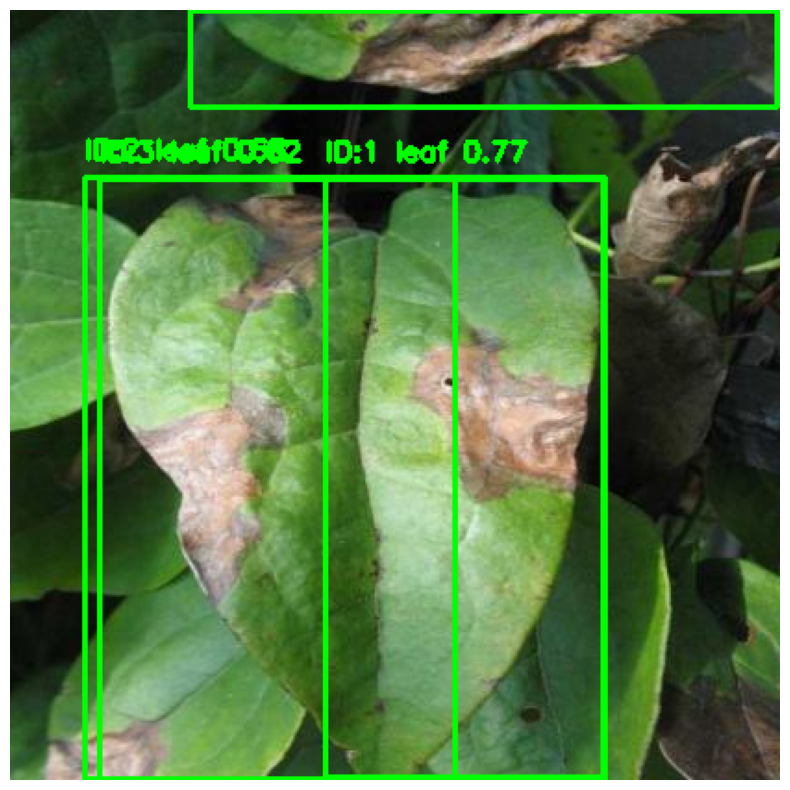


0: 416x416 27 leafs, 8.2ms
Speed: 1.4ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


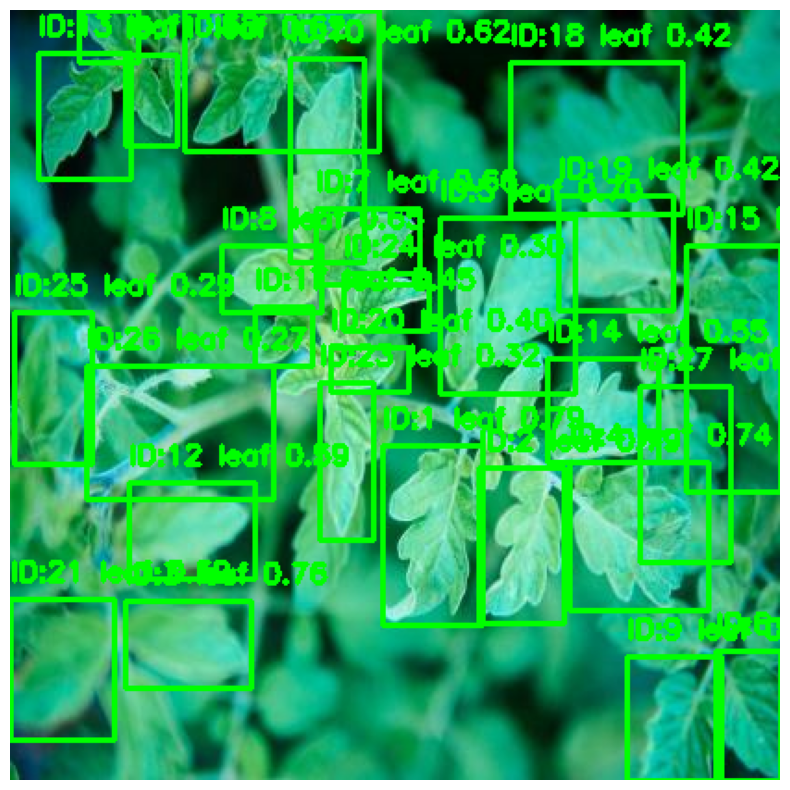


0: 416x416 11 leafs, 9.2ms
Speed: 1.9ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


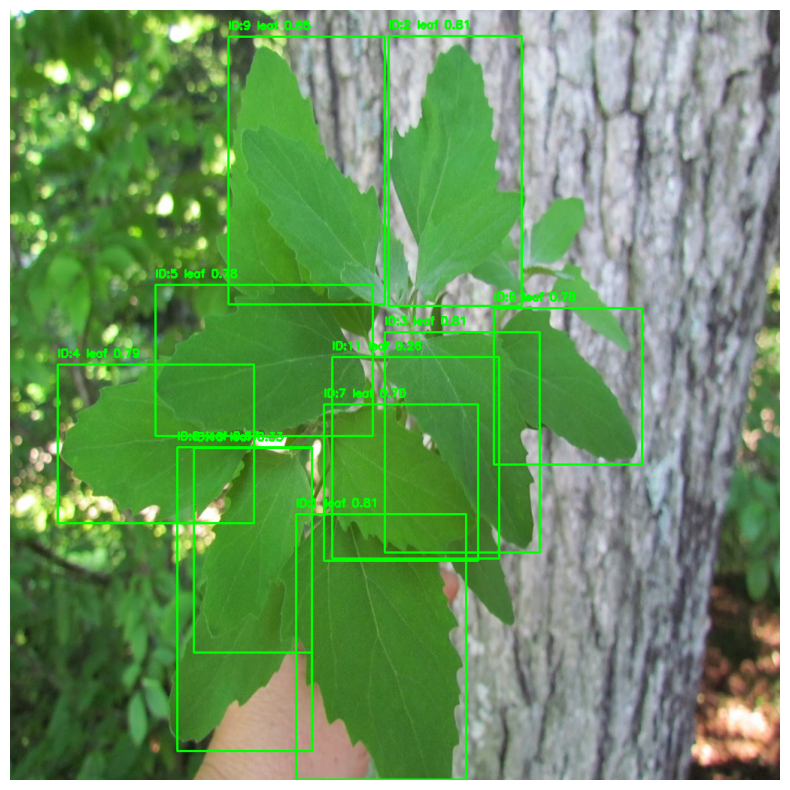


0: 416x416 3 leafs, 8.6ms
Speed: 1.1ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


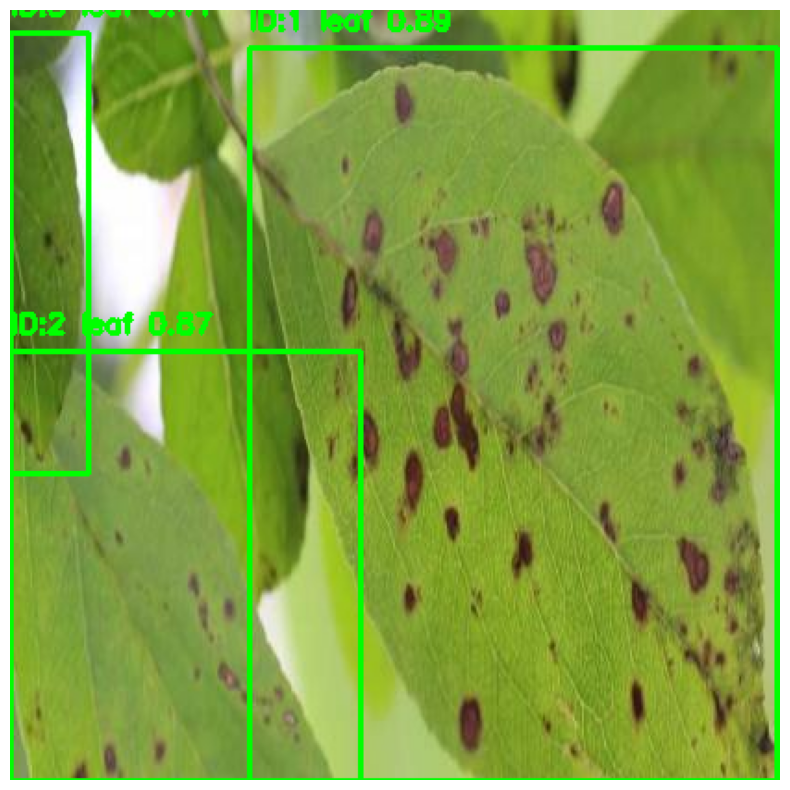


0: 416x416 1 leaf, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)


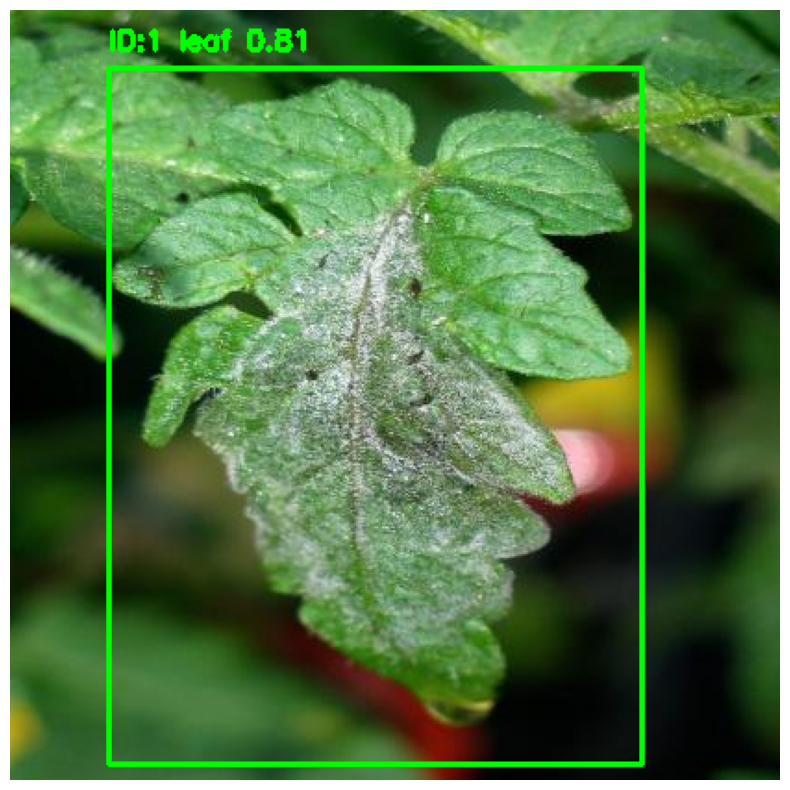

In [13]:
# Show detections with IDs on test images
show_detections_with_ids(test_images_dir, model, num_images=5)


## Verify the CSV Output

In [1]:
# Read and display the CSV file
df_detections = pd.read_csv(output_csv_path)
print(df_detections.head())


NameError: name 'pd' is not defined